In [1]:
import sys
from cv2 import VideoCapture,cvtColor, absdiff,COLOR_BGR2RGB,COLOR_BGR2GRAY,CAP_PROP_FPS,CAP_PROP_FRAME_COUNT
from mediapipe.python.solutions.face_mesh import FaceMesh
from mediapipe.python.solutions.face_detection import FaceDetection
from pandas import read_csv, concat,DataFrame
from numpy import mean
from time import sleep
from glob import glob
from shutil import copy, move
import matplotlib.pyplot as plt
from gc import collect
import random
import numpy as np
from subprocess import run, Popen,DEVNULL, PIPE, STDOUT


In [2]:
face_mesh = FaceMesh(min_detection_confidence=0)
face_detection = FaceDetection(model_selection=2, min_detection_confidence=0)

In [3]:
WORK_DIR = r"E:/Video Links Dataset"
CLIPPED_VIDEOS = WORK_DIR + r"/clipped/videos"
CLIPPED_ALIGNMENTS = WORK_DIR + r"/clipped/alignments"
DOWNLOADED_VIDEOS = WORK_DIR + r"/downloaded/videos"
DOWNLOADED_ALIGNMENTS = WORK_DIR + r"/downloaded/alignments"
FILTERED_VIDEOS = WORK_DIR + r"/filtered/videos"
FILTERED_ALIGNMENTS = WORK_DIR + r"/filtered/alignments"
LINK_DATASET = WORK_DIR + r"/Video Links Dataset.csv"
STATUS_DATASET = WORK_DIR + r"/Video Status.csv"
LOG_FILE_DOWN = WORK_DIR + r"/log_down.txt"
LOG_FILE_CLIP = WORK_DIR + r"/log_clip.txt"
LOG_FILE_FILT = WORK_DIR + r"/log_filt.txt"
PICKELS = WORK_DIR + r"/pickles"
DOWNLOADER = r"scripts/download_video.py"
CLIPPER = r"scripts/clip_video.py"
FILTERER = r'scripts/filter_videos.py'
RUNTIME = sys.executable.replace('\\','/')


In [3]:
videos = 500
list_of_videos = [x.replace("\\","/") for x in glob(CLIPPED_VIDEOS+r"/*.mp4")]

In [59]:
min_frames = []
max_frames = []
mean_frames = []
median_frames = []
threshold_frames = []

min_lips = []
max_lips = []
mean_lips = []
median_lips = []
threshold_lips = []

names=[]


In [4]:
def zscore_scale(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = [(x - mean) / std_dev for x in data]
    return z_scores

def find_threshold(numbers,threshold):

    mean = sum(numbers) / len(numbers)
    
    variance = sum((x - mean) ** 2 for x in numbers) / len(numbers)
    std_dev = variance ** 0.5
    
    upper_threshold = mean + (threshold * std_dev)

    return upper_threshold 

def threshold_check(numbers, threshold):
    mean = sum(numbers) / len(numbers)
    variance = sum((x - mean) ** 2 for x in numbers) / len(numbers)
    std_dev = variance ** 0.5

    upper_threshold = mean + (threshold * std_dev)
    
    thresholded_list = [1 if z >= upper_threshold else 0 for z in numbers]
    
    return thresholded_list

In [61]:
def video_is_accpeted(video_path):

    try:

        cap = VideoCapture(video_path)
        if not cap.isOpened():
            cap.release()
            return

        # lip coordinates,
        lip_pairs = [[13, 14], [82, 87], [312, 317],[81,178],[311,402],[310,318],[80,88]]

        # list for whether frames are lips are moving rapidly
        lip_diffs = []
        frame_diffs = []
        prev_frame = None
        first = True
        prev_lip = None

        # loop over all frames in the video
        for _ in range(int(cap.get(CAP_PROP_FRAME_COUNT))):
            ret, frame = cap.read()

            if not ret:
                continue

            if not first:
                diff = absdiff(prev_frame, frame)

                gray_diff = cvtColor(diff, COLOR_BGR2GRAY)
                avg_diff = mean(gray_diff)
                frame_diffs.append(avg_diff)

            prev_frame = frame.copy()
            first = False

            # convert to rgb
            frame = cvtColor(frame, COLOR_BGR2RGB)

            face_detection_result = face_detection.process(frame)
            face_mesh_result = face_mesh.process(frame)
            

            if face_detection_result.detections == None:
                continue

            if (len(face_detection_result.detections) !=1) or (not face_mesh_result.multi_face_landmarks) :
                continue
            

   
            for face_landmarks in face_mesh_result.multi_face_landmarks:

                landmarks = face_landmarks.landmark
                    
                lip_diff = 0
                for lip_pair in lip_pairs:
                    upper_lip_x, upper_lip_y = int(
                        landmarks[lip_pair[0]].x * frame.shape[1]
                    ), int(landmarks[lip_pair[0]].y * frame.shape[0])
                    lower_lip_x, lower_lip_y = int(
                        landmarks[lip_pair[1]].x * frame.shape[1]
                    ), int(landmarks[lip_pair[1]].y * frame.shape[0])
                    lip_diff += ((upper_lip_x - lower_lip_x) ** 2) + (
                        (upper_lip_y - lower_lip_y) ** 2
                    )

                if prev_lip != None:
                    lip_diffs.append(abs(prev_lip-lip_diff))
                prev_lip = float(lip_diff)

        if(len(lip_diffs) == 0):
           return
        
        names.append(video_path.split(r"/")[-1].split(r".mp")[0].strip())

        min_frames.append(min(frame_diffs))
        max_frames.append(max(frame_diffs))
        mean_frames.append(sum(frame_diffs)/len(frame_diffs))
        median_frames.append(np.median(frame_diffs))
        threshold_frames.append(find_threshold(frame_diffs,1))


        min_lips.append(min(lip_diffs))
        max_lips.append(max(lip_diffs))
        mean_lips.append(sum(lip_diffs)/len(lip_diffs))
        median_lips.append(np.median(lip_diffs))
        threshold_lips.append(find_threshold(lip_diffs,1))


        cap.release()

    except Exception as e:
        print(e)
        cap.release()
        return


In [62]:
while videos:
    video_is_accpeted(random.choice(list_of_videos))
    videos -= 1
videos = 500

C:\Users\Mgala\AppData\Roaming\Python\Python39\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [63]:
data = {
    "name":names,
    "min_frames": min_frames,
    "max_frames": max_frames,
    "mean_frames": mean_frames,
    "median_frames": median_frames,
    "threshold_frames": threshold_frames,
    "min_lips": min_lips,
    "max_lips": max_lips,
    "mean_lips": mean_lips,
    "median_lips": median_lips,
    "threshold_lips": threshold_lips
}

# Create DataFrame
df = DataFrame(data)
df.head()

,name,min_frames,max_frames,mean_frames,median_frames,threshold_frames,min_lips,max_lips,mean_lips,median_lips,threshold_lips
0,R_103_391,0.517303,28.546304,3.773403,2.710165,7.172381,0.0,1551.0,68.666667,22.0,269.321151
1,R_100_135,0.099293,0.711722,0.319205,0.302180,0.438441,0.0,174.0,51.140351,37.0,93.558668
2,R_104_335,0.216457,2.619083,0.795804,0.725957,1.249417,3.0,1969.0,244.621622,68.0,632.632861
3,R_105_97,0.055112,32.696842,1.623549,0.991132,4.781583,0.0,4392.0,306.326733,54.0,932.784543
4,R_10_203,1.446648,5.735891,2.964636,2.715413,3.954998,0.0,1956.0,372.930233,164.0,868.511399


In [4]:
from sklearn.cluster import Birch


In [65]:
df.to_csv("thresholds.csv",index=False)

In [5]:
df = read_csv("thresholds.csv")
df.head()

,name,min_frames,max_frames,mean_frames,median_frames,threshold_frames,min_lips,max_lips,mean_lips,median_lips,threshold_lips
0,R_103_391,0.517303,28.546304,3.773403,2.710165,7.172381,0.0,1551.0,68.666667,22.0,269.321151
1,R_100_135,0.099293,0.711722,0.319205,0.302180,0.438441,0.0,174.0,51.140351,37.0,93.558668
2,R_104_335,0.216457,2.619083,0.795804,0.725957,1.249417,3.0,1969.0,244.621622,68.0,632.632861
3,R_105_97,0.055112,32.696842,1.623549,0.991132,4.781583,0.0,4392.0,306.326733,54.0,932.784543
4,R_10_203,1.446648,5.735891,2.964636,2.715413,3.954998,0.0,1956.0,372.930233,164.0,868.511399


In [57]:
X = df[['max_frames','threshold_frames']]

model = Birch(threshold=0.01, n_clusters=2)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# Add cluster labels to DataFrame

df['cluster_frames'] = yhat

df.head()

,name,min_frames,max_frames,mean_frames,median_frames,threshold_frames,min_lips,max_lips,mean_lips,median_lips,threshold_lips,cluster_frames
0,R_103_391,0.517303,28.546304,3.773403,2.710165,7.172381,0.0,1551.0,68.666667,22.0,269.321151,0
1,R_100_135,0.099293,0.711722,0.319205,0.302180,0.438441,0.0,174.0,51.140351,37.0,93.558668,0
2,R_104_335,0.216457,2.619083,0.795804,0.725957,1.249417,3.0,1969.0,244.621622,68.0,632.632861,0
3,R_105_97,0.055112,32.696842,1.623549,0.991132,4.781583,0.0,4392.0,306.326733,54.0,932.784543,0
4,R_10_203,1.446648,5.735891,2.964636,2.715413,3.954998,0.0,1956.0,372.930233,164.0,868.511399,0


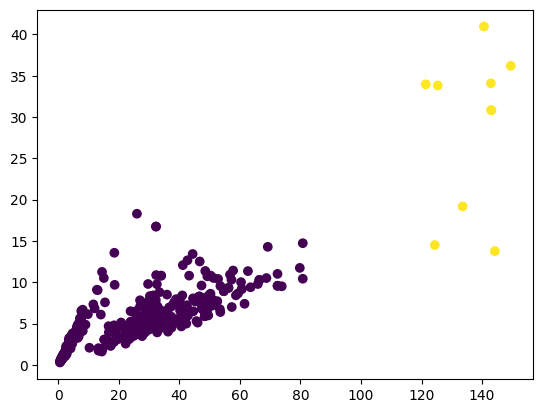

In [59]:
plt.scatter(df['max_frames'],df['threshold_frames'],c=df['cluster_frames'])

In [1]:

thres = 4
((df['threshold_frames'] * thres > df['max_frames']) & (df['cluster_frames'] == 0)).sum() + (((df['threshold_frames'] * thres < df['max_frames']) & (df['cluster_frames'] == 1))).sum()

NameError: name 'df' is not defined

In [60]:
df[df['cluster_frames']==0]

,name,min_frames,max_frames,mean_frames,median_frames,threshold_frames,min_lips,max_lips,mean_lips,median_lips,threshold_lips,cluster_frames
36,R_107_444,0.215645,133.600464,3.231478,0.983434,19.177112,9.0,4898.0,1127.235294,920.5,2189.747413,1
119,R_104_98,0.112733,124.375566,2.419524,0.697896,14.498693,0.0,54.0,10.616071,8.0,20.707834,1
139,R_108_8,0.036456,143.075647,6.737122,0.670528,30.828536,0.0,152.0,17.307692,9.0,43.829047,1
150,R_104_107,0.073451,125.349118,8.090174,1.296560,33.820609,41.0,41.0,41.000000,41.0,41.000000,1
253,R_108_31,0.046654,142.910923,8.041019,1.582945,34.081066,0.0,229.0,81.142857,73.0,148.397020,1
274,R_100_388,0.040506,149.502922,9.239320,0.713528,36.202078,1.0,7169.0,1696.652174,458.0,3976.440772,1
330,R_108_12,0.059753,144.245191,1.765063,0.688341,13.766513,0.0,501.0,29.985075,2.0,124.436435,1
332,R_103_191,0.027217,143.031585,6.751226,0.685602,30.835655,0.0,158.0,13.190476,7.0,39.635302,1
345,R_101_114,0.000388,140.630146,10.601856,1.354474,40.961704,1.0,274.0,82.034483,75.0,150.831778,1
348,R_100_136,0.005809,121.405844,8.257091,0.343535,33.963351,0.0,68.0,16.526316,12.0,32.917483,1


In [61]:
df[df['cluster_frames']==0]

,name,min_frames,max_frames,mean_frames,median_frames,threshold_frames,min_lips,max_lips,mean_lips,median_lips,threshold_lips,cluster_frames
0,R_103_391,0.517303,28.546304,3.773403,2.710165,7.172381,0.0,1551.0,68.666667,22.0,269.321151,0
1,R_100_135,0.099293,0.711722,0.319205,0.302180,0.438441,0.0,174.0,51.140351,37.0,93.558668,0
2,R_104_335,0.216457,2.619083,0.795804,0.725957,1.249417,3.0,1969.0,244.621622,68.0,632.632861,0
3,R_105_97,0.055112,32.696842,1.623549,0.991132,4.781583,0.0,4392.0,306.326733,54.0,932.784543,0
4,R_10_203,1.446648,5.735891,2.964636,2.715413,3.954998,0.0,1956.0,372.930233,164.0,868.511399,0
...,...,...,...,...,...,...,...,...,...,...,...,...
402,R_101_440,1.315136,32.277528,9.036645,6.190583,16.740217,1.0,4699.0,633.541176,232.0,1526.204509,0
403,R_103_109,0.071373,48.083377,2.117418,1.978457,6.584916,0.0,32.0,5.772727,3.0,13.721037,0
404,R_103_327,0.081149,49.538908,1.023518,0.299265,5.981008,0.0,2510.0,109.132653,15.0,421.229140,0
405,R_103_109,0.071373,48.083377,2.117418,1.978457,6.584916,0.0,22.0,4.636364,3.0,9.540401,0


In [68]:
clean_cluster  = df[df['cluster_frames']==0]

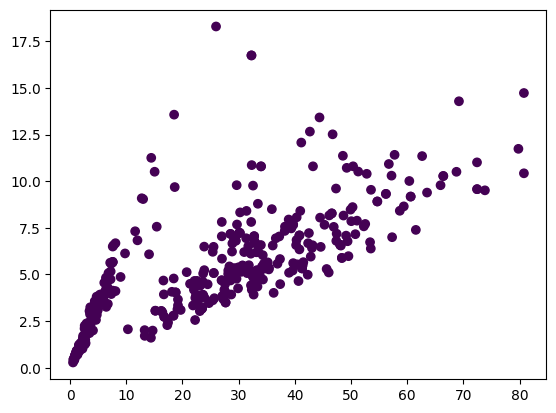

In [75]:
plt.scatter(clean_cluster['max_frames'],clean_cluster['threshold_frames'],c=clean_cluster['cluster_frames'])


In [71]:
(clean_cluster['threshold_frames']*3 > clean_cluster['max_frames']).sum()

145

In [87]:
clean_cluster['max_lips'].shape

(10,)

In [ ]:
mustache = []
clean  = []

# Check if lip not moving detection is working

In [5]:
bad_lips = ["4_300","4_380","4_654","4_961","4_977","4_978","4_979"]
good_lips = ["4_108","4_20","3_304","3_228","3_217","4_732","4_698"]
good_lips_y = []
bad_lips_y=[]

In [6]:
import math

for bad in bad_lips:
    video_path = FILTERED_VIDEOS + fr"/{bad}.mp4"     
    cap = VideoCapture(video_path)

    if not cap.isOpened():
        cap.release()
        continue

    lip_pairs = [[13, 14]]

    lip_diffs = []
    first = True
    prev_lip = None

    # loop over all frames in the video
    for _ in range(int(cap.get(CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()

        if not ret:
            continue

        # convert to rgb
        frame = cvtColor(frame, COLOR_BGR2RGB)

        face_detection_result = face_detection.process(frame)
        face_mesh_result = face_mesh.process(frame)
        

        if face_detection_result.detections == None:
            continue

        if (len(face_detection_result.detections) !=1) or (not face_mesh_result.multi_face_landmarks) :
            continue
        


        for face_landmarks in face_mesh_result.multi_face_landmarks:

            landmarks = face_landmarks.landmark
                
            lip_diff = 0
            for lip_pair in lip_pairs:
                upper_lip_x, upper_lip_y = int(
                    landmarks[lip_pair[0]].x * frame.shape[1]
                ), int(landmarks[lip_pair[0]].y * frame.shape[0])
                lower_lip_x, lower_lip_y = int(
                    landmarks[lip_pair[1]].x * frame.shape[1]
                ), int(landmarks[lip_pair[1]].y * frame.shape[0])
                lip_diff += ((upper_lip_x - lower_lip_x) ** 2) + (
                    (upper_lip_y - lower_lip_y) ** 2
                )
        lip_diffs.append(math.sqrt(lip_diff))
        # if prev_lip != None:
        #     lip_diffs.append(abs(prev_lip-math.sqrt(lip_diff)))

        # prev_lip = float(math.sqrt(lip_diff))
    
    bad_lips_y.append(zscore_scale(lip_diffs))
    print("done: ",bad)
    cap.release()


done:  4_300
done:  4_380
done:  4_654
done:  4_961
done:  4_977
done:  4_978
done:  4_979


In [7]:
x = 0
for i in bad_lips_y:
    x+= sum(i)/len(i)
print(x/7)

1.9658274365775917e-16


In [8]:
import math

for bad in good_lips:
    video_path = FILTERED_VIDEOS + fr"/{bad}.mp4"     
    cap = VideoCapture(video_path)

    if not cap.isOpened():
        cap.release()
        continue

    lip_pairs = [[13, 14]]

    lip_diffs = []
    first = True
    prev_lip = None

    # loop over all frames in the video
    for _ in range(int(cap.get(CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()

        if not ret:
            continue

        # convert to rgb
        frame = cvtColor(frame, COLOR_BGR2RGB)

        face_detection_result = face_detection.process(frame)
        face_mesh_result = face_mesh.process(frame)
        

        if face_detection_result.detections == None:
            continue

        if (len(face_detection_result.detections) !=1) or (not face_mesh_result.multi_face_landmarks) :
            continue
        


        for face_landmarks in face_mesh_result.multi_face_landmarks:

            landmarks = face_landmarks.landmark
                
            lip_diff = 0
            for lip_pair in lip_pairs:
                upper_lip_x, upper_lip_y = int(
                    landmarks[lip_pair[0]].x * frame.shape[1]
                ), int(landmarks[lip_pair[0]].y * frame.shape[0])
                lower_lip_x, lower_lip_y = int(
                    landmarks[lip_pair[1]].x * frame.shape[1]
                ), int(landmarks[lip_pair[1]].y * frame.shape[0])
                lip_diff += ((upper_lip_x - lower_lip_x) ** 2) + (
                    (upper_lip_y - lower_lip_y) ** 2
                )

        lip_diffs.append(math.sqrt(lip_diff))
        # if prev_lip != None:
        #     lip_diffs.append(abs(prev_lip-math.sqrt(lip_diff)))

        # prev_lip = float(math.sqrt(lip_diff))
    
    good_lips_y.append(zscore_scale(lip_diffs))
    print("done: ",bad)
    cap.release()


done:  4_108
done:  4_20
done:  3_304
done:  3_228
done:  3_217
done:  4_732
done:  4_698


In [9]:
x = 0
for i in good_lips_y:
    x+= sum(i)/len(i)
print(x/7)

-1.7010096121753151e-16


In [10]:
for i in good_lips_y:
    print(sum(i)/len(i))

4.594026308793751e-17
-2.0185873175002847e-17
-4.987958516431863e-16
-5.853903220750825e-16
-6.141659285160441e-17
-2.7755575615628914e-17
-4.310277625015314e-17


In [11]:
for i in bad_lips_y:
    print(sum(i)/len(i))

-1.211591213830062e-15
2.639863636330928e-16
8.625578883626216e-17
7.656710514656252e-18
7.208164413611091e-16
1.829045389721444e-15
-3.2009027463218797e-16


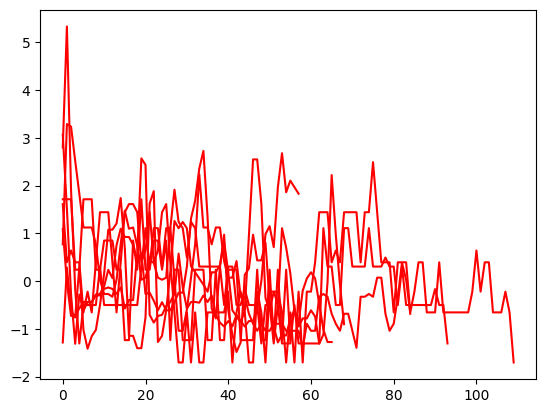

In [12]:
for i in good_lips_y:
    plt.plot(i,color="red")


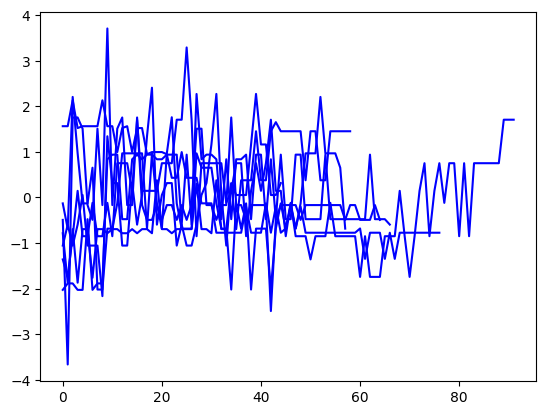

In [13]:
for i in bad_lips_y:
    plt.plot(i,color="blue")

In [12]:
result = run([RUNTIME,FILTERER ,"10","2"],universal_newlines = True,stdout = PIPE ,stderr = STDOUT)

print(result.stdout)

C:\Users\Mgala\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Mgala\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
0.6665253868607667
False

